# Plot cross-section of the strain
2024.01.10 Kurama Okubo

We plotted the cross-section of dilation for the 2004 Parkfield earthquake.

Please first compute the strain using coulomb33.

- 2024.01.16 update with new elastic parameters.

In [1]:
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline

from pyproj import Proj # used to convert between utm and lat lon

import numpy as np
import pandas as pd
import h5py
import glob
import pickle

import shutil
from tqdm import tqdm

import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter

import matplotlib as mpl

# modules to compute distance
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

import seaborn as sns


plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion


In [2]:
output_imgdir = "../figure/"

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)
    

In [3]:
# read BP station metadata
# read station loc and depth
loc_table = "../data/BP_gmap-stations.txt"
df_raw = pd.read_csv(loc_table, skiprows=3, header=None, sep = '|')

stationidlist = []
for i, row in df_raw.iterrows():
    stationidlist.append("{}.{}".format(row[0], row[1]))
    
dict_loc = {"id": stationidlist,
            "station": df_raw[1],
            "latitude": df_raw[2],
            "longitude": df_raw[3],
            "elevation": df_raw[4],
}
df_locorigin = pd.DataFrame.from_dict(dict_loc)

In [4]:
#make list of station depth
# Instrument depth is available in Malagnini2016 Table 1

stationdepth = {}
stationdepth["EADB"]=245
stationdepth["FROB"]=284
stationdepth["GHIB"]=63
stationdepth["JCNB"]=224
stationdepth["JCSB"]=155
stationdepth["MMNB"]=221
stationdepth["RMNB"]=73
stationdepth["SMNB"]=282 
stationdepth["VARB"]=298 
stationdepth["VCAB"]=200 
stationdepth["CCRB"]=251 
stationdepth["LCCB"]=252 
stationdepth["SCYB"]=252

df_stationdepth = pd.DataFrame(columns=["station", "depth"])
for d in stationdepth:
    df_stationdepth = pd.concat([df_stationdepth, pd.DataFrame({'station': d, 'depth': [stationdepth[d]]})])

df_locorigin = pd.merge(df_locorigin, df_stationdepth, on='station')
df_locorigin = df_locorigin.sort_values(by="station")
df_locorigin

,id,station,latitude,longitude,elevation,depth
0,BP.CCRB,CCRB,35.95718,-120.55158,595.0,251
1,BP.EADB,EADB,35.89522,-120.42262,469.0,245
2,BP.FROB,FROB,35.91095,-120.48688,515.0,284
3,BP.GHIB,GHIB,35.83225,-120.34728,393.0,63
4,BP.JCNB,JCNB,35.93897,-120.43112,533.0,224
5,BP.JCSB,JCSB,35.92117,-120.43400,454.0,155
6,BP.LCCB,LCCB,35.98006,-120.51423,637.0,252
7,BP.MMNB,MMNB,35.95650,-120.49600,701.0,221
8,BP.RMNB,RMNB,36.00087,-120.47772,1164.0,73
9,BP.SCYB,SCYB,36.00942,-120.53661,947.0,252


In [5]:
# Using readlines()
fi = open('../data/historicalfaults.txt', 'r')
lines = fi.readlines()

dict_sf = {}
faultcount = 0
# Strips the newline character
linecount = 0
while linecount < len(lines):
    # initialize fault
    faultcount += 1
    x1 = []
    y1 = []
    while True:
        line = lines[linecount]
        linecount = linecount+1
        if ">" in line:
            dict_sf["fault{:d}".format(faultcount)] = [x1, y1]
            break
        else:
            x1.append(float(line.split("\t")[0]))
            y1.append(float(line.split("\t")[1]))

# Compute the cross section

We compute the cross-sections along the approximated fault and the orthogonal line.
We need to convert to xy coordinate to compute the orthogonal line

In [6]:
approx_faultloc = np.ravel(np.loadtxt("../data/approx_faultloc.txt", delimiter=","))
approx_faultloc


array([-120.65 ,   36.085, -120.35 ,   35.82 ])

In [7]:
utm_zone_BP = 10
p = Proj(proj='utm', zone=utm_zone_BP,ellps='WGS84', preserve_units=False)
# x, y = p(lon, lat)


In [8]:
A0 = p(approx_faultloc[0], approx_faultloc[1])
B0 = p(approx_faultloc[2], approx_faultloc[3])

y0 = lambda x: ((B0[1]-A0[1])/(B0[0]-A0[0])) * (x - A0[0]) + A0[1]

In [9]:
C0_k = 0.45
C0_x = A0[0] + C0_k*(B0[0] - A0[0])

In [10]:
C0 = [C0_x, y0(C0_x)]
C0_ll = p(C0[0], C0[1], inverse=True)

In [11]:
C0_ll

(-120.5147526566392, 35.96583440617743)

In [12]:
k1 = -(B0[0]-A0[0])/(B0[1]-A0[1]) # slope of cross-section 
cross_theta = np.arctan(k1)

L = 2e4 #[m]

A1 = [-L*np.cos(cross_theta)+C0[0], -L*np.sin(cross_theta)+C0[1]]
B1 = [L*np.cos(cross_theta)+C0[0], L*np.sin(cross_theta)+C0[1]]

In [13]:
A1, B1

([709744.7027174239, 3969097.118743997],
 [738471.2844605041, 3996932.051856152])

In [14]:
A1_ll = p(A1[0], A1[1], inverse=True)
B1_ll = p(B1[0], B1[1], inverse=True)

In [15]:
A1_ll, B1_ll

((-120.6775808633468, 35.843649386970604),
 (-120.35142385384519, 36.08777545398971))

In [16]:
# Compute location of edges for the coulomb33
# Zero coordinate from s2004PARKFI01JIxx_200f_coulomb.mat downloaded from http://equake-rc.info/SRCMOD/searchmodels/viewmodel/s2004PARKFI01JIxx/
ZERO_LON = -120.36703
ZERO_LAT = 35.82363

G0 = p(ZERO_LON, ZERO_LAT, inverse=False)

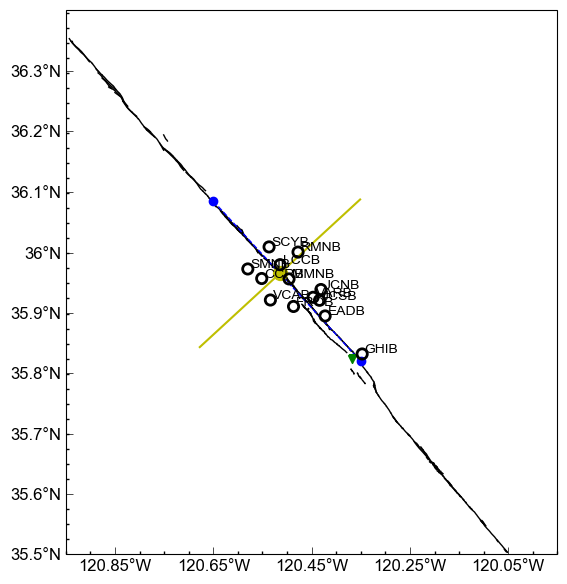

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.Mercator()})
f_lon_min = -120.95 #-120.625
f_lon_max = -119.95 #-120.3
f_lat_min = 35.5 #35.775
f_lat_max = 36.4 #36.07

#---Plot stations---#
for k, row in df_locorigin.iterrows():
    staid = row.id
    sta = row.station
    lon, lat, elevation, depth = row.longitude, row.latitude, row.elevation, row.depth
    ax.scatter(lon,lat, s=55, facecolors='none',  edgecolors='black',
                    linestyle="-", linewidth=2, zorder=6, transform=ccrs.PlateCarree())
    ax.text(lon+0.005, lat+0.001, sta, fontsize=10, transform=ccrs.PlateCarree())


#---plot fault geometry---#
for sfkey in dict_sf:
    faultx = dict_sf[sfkey][0]
    faulty = dict_sf[sfkey][1]
    min_x, min_y = [np.min(faultx), np.min(faulty)]
    max_x, max_y = [np.max(faultx), np.max(faulty)]

    if (min_x > f_lon_min) & (max_x < f_lon_max) & (min_y > f_lat_min) & (max_y < f_lat_max):
        ax.plot(faultx, faulty, 'k', ls="-", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
#-------------------------------#

#---Plot approximated fault loc---#
ax.plot([approx_faultloc[0], approx_faultloc[2]], [approx_faultloc[1], approx_faultloc[3]],
            'bo', ls="--", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
#-------------------------------------------#

#---Plot cross-section---#
ax.plot(C0_ll[0], C0_ll[1], "o", c="y", ms=10, transform=ccrs.PlateCarree())
ax.plot([A1_ll[0], B1_ll[0]], [A1_ll[1], B1_ll[1]], "y-", transform=ccrs.PlateCarree())
ax.plot(ZERO_LON, ZERO_LAT, "gv", transform=ccrs.PlateCarree())

#-------------------------------------------#

ax.set_extent([f_lon_min, f_lon_max, f_lat_min, f_lat_max], crs=ccrs.PlateCarree())

ax.set_xticks(np.arange(-120.85, -119.95, 0.2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(35.5, 36.4, 0.1), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True, dms=False)
lat_formatter = LatitudeFormatter(dms=False)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()

# Plot the cross-section of the strain

# project the location of stations to the cross-section

1. compute unit vector along cross-section
2. compute dot product to compute the coordinate along cross-section

In [18]:
n1 = (np.array(B1) - np.array(A1))/np.linalg.norm(np.array(B1) - np.array(A1))

In [19]:
df_station_cs = pd.DataFrame(columns=["id", "X"])

for k, row in df_locorigin.iterrows():
    S0 = p(row.longitude, row.latitude, inverse=False) - np.array(A1)
    X = np.dot(S0, n1)/1e3
    df_station_cs = pd.concat([df_station_cs, pd.DataFrame({"id": [row.id], "X":[X]})])
    
df_station_cs

,id,X
0,BP.CCRB,16.905255
0,BP.EADB,20.814708
0,BP.FROB,17.725556
0,BP.GHIB,21.100460
0,BP.JCNB,23.535571
0,BP.JCSB,22.007230
0,BP.LCCB,21.104072
0,BP.MMNB,20.543228
0,BP.RMNB,25.091126
0,BP.SCYB,21.826632


## Compute the projection of the fault on the cross-section

We use fault_int_sec implemented in `coulomb33/sources/fault_int_sec.m` to compute the fault location projected on the cross-section.
See `BP_computeFaultgeom.m`.

In [20]:
#The projected fault is  19.88991240,  -0.00000000,  18.12248307, -14.39191920.
fault_crosssection = [19.88991240,  -0.00000000,  18.12248307, -14.39191920]

In [21]:
## Load strain on the cross-section
df_strain = pd.read_csv("../../SourceModel/coulomb33_inputfiles/dilatation_section_BP.cou", skiprows=3, header=None, delim_whitespace=True, names=["x", "y", "z", "dilatation", "dilatation_0", "dilatation_1"])


In [22]:
x0 = df_strain.iloc[0]["x"]
y0 = df_strain.iloc[0]["y"]
x0, y0

(-27.81, 2.09)

### Compute section

In [23]:
def compute_X(x, y, x0, y0):
    return np.linalg.norm([(x - x0), (y - y0)])

In [24]:
df_strain['X_section'] = df_strain.apply(lambda x: compute_X(x.x, x.y, x0, y0), axis=1).round(5)

In [25]:
Nx = len(np.unique(df_strain["X_section"].round(5)))
Nz = len(np.unique(df_strain["z"]))

In [26]:
df_strain

,x,y,z,dilatation,dilatation_0,dilatation_1,X_section
0,-27.81,2.09,-0.0,-1.116438e-07,-1.116438e-07,-1.116438e-07,0.00000
1,-27.81,2.09,0.2,-1.108249e-07,-1.108249e-07,-1.108249e-07,0.00000
2,-27.81,2.09,0.4,-1.100273e-07,-1.100273e-07,-1.100273e-07,0.00000
3,-27.81,2.09,0.6,-1.092504e-07,-1.092504e-07,-1.092504e-07,0.00000
4,-27.81,2.09,0.8,-1.084935e-07,-1.084935e-07,-1.084935e-07,0.00000
...,...,...,...,...,...,...,...
8176,0.92,29.92,19.2,4.239313e-08,4.239313e-08,4.239313e-08,39.99902
8177,0.92,29.92,19.4,4.177504e-08,4.177504e-08,4.177504e-08,39.99902
8178,0.92,29.92,19.6,4.116101e-08,4.116101e-08,4.116101e-08,39.99902
8179,0.92,29.92,19.8,4.055121e-08,4.055121e-08,4.055121e-08,39.99902


In [27]:
Nx, Nz

(81, 101)

In [28]:
xq = np.reshape(df_strain["X_section"], (Nx, Nz))
yq = np.reshape(df_strain["z"], (Nx, Nz))
zq = np.reshape(df_strain["dilatation"], (Nx, Nz))

## Plot contour of strain

In [29]:
# use the same colormap with the strain of Figure 13
cmap_name ='20,250'
zmin=-15
zmax=15
zstep=0.01
zl = np.arange(zmin, zmax+0.5*zstep, zstep)
Nzl = len(zl)


divc = np.array([float(x) for x in cmap_name.split(",")])
# lc = 
cmap = sns.diverging_palette(divc[0], divc[1], s=60, n=Nzl, as_cmap=True)

In [30]:
# cmap = "RdBu"

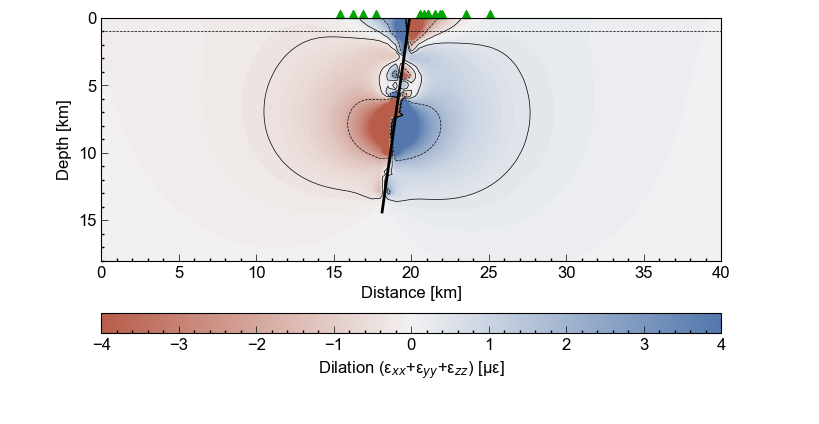

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))

# Ncontourf = 2001#201
Ncontourf=np.linspace(-10, 10, 201)
vmin=-4
vmax=4
norm_Z = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

depth = 1.0 # depth at which we computed the horizontal strain distribution

# Plot contourf
ax.contourf(xq, yq, zq*1e6, Ncontourf, norm=norm_Z, zorder=-10, cmap=cmap, extend="both")
# ax.pcolormesh(xq, yq, zq*1e6, norm=norm_Z, zorder=-10, cmap=cmap)
ax.contour(xq, yq, zq*1e6, [-0.4, 0.4], norm=norm_Z, colors='k', linestyles = '-', zorder=-9, linewidths=0.5)
ax.contour(xq, yq, zq*1e6, [-2, 2], norm=norm_Z, colors='k', linestyles = '--', zorder=-9, linewidths=0.5)

# Plot fault
ax.plot([fault_crosssection[0], fault_crosssection[2]], [fault_crosssection[1], -fault_crosssection[3]], "k-", lw=2)

# Plot stations
for i, row in df_station_cs.iterrows():
    ax.plot(row.X, -0.3, "^", c="#00A500", ms=6, clip_on=False)

ax.axhline(depth, ls="--", c="k", lw=0.5)
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Depth [km]")
ax.set_xlim([0, 40])
ax.set_ylim([0, 18])

ax.invert_yaxis()

cbar_ax = fig.add_axes([0.011, 0.0, 1, 0.2])
cbar_ax.set_axis_off()

cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm_Z, cmap=cmap),
                 orientation='horizontal', ax=ax, location = 'bottom',
                 label=r"Dilation (ε$_{xx}$+ε$_{yy}$+ε$_{zz}$) [µε]", aspect=30)

foname = (output_imgdir+"/BP_dilation_crosssection.png")
plt.savefig(foname, dpi=150)

foname = (output_imgdir+"/BP_dilation_crosssection.eps")
plt.savefig(foname)

In [32]:
df_station_cs

,id,X
0,BP.CCRB,16.905255
0,BP.EADB,20.814708
0,BP.FROB,17.725556
0,BP.GHIB,21.100460
0,BP.JCNB,23.535571
0,BP.JCSB,22.007230
0,BP.LCCB,21.104072
0,BP.MMNB,20.543228
0,BP.RMNB,25.091126
0,BP.SCYB,21.826632
